# 목표 
- 월별/분기별 흥행 장르 파악하기
    - 사용 지표 : 평점, 수익, 인기도
    - 월별/분기별로 장르의 평점, 수익, 인기도를 확인한다.
- 작가, 회사, 감독 등의 요인을 배제하고 오직 시기와 장르의 연관을 확인한다.
- 개봉일과 평점, 수익, 인기도는 '숫자'로 되어 있어 바로 계산이 가능하다. -> 1차 목표로 둔다.
- 작가, 회사, 감독 등은 '문자열'이다. -> 2차 목표로 남겨둔다.

# 0. 전처리 

In [1]:
import pandas as pd

# 원본 데이터 파일 경로를 지정해주세요.
# 예: 'movies_data.csv'
input_file_path = '/kaggle/input/tmdb-raw-data/TMDB_all_movies.csv'
# 저장할 파일 경로를 지정해주세요.
output_file_path = 'processed.csv'

try:
    # 1. CSV 파일을 데이터프레임으로 읽어옵니다.
    df = pd.read_csv(input_file_path)

    # 2. 필요한 컬럼만 선택합니다.
    columns_to_keep = ['id', 'title', 'release_date', 'vote_average', 'revenue', 'popularity', 'genres']
    df_selected = df[columns_to_keep]

    # 3. 'release_date' 컬럼을 datetime 형식으로 변환합니다. 
    #    변환 중 오류가 발생하는 데이터는 NaT(Not a Time)으로 처리됩니다.
    df_selected['release_date'] = pd.to_datetime(df_selected['release_date'], errors='coerce')

    # 4. 2010년에서 2025년 사이의 데이터만 필터링합니다.
    #    먼저, 유효한 날짜 데이터만 남깁니다.
    df_filtered = df_selected.dropna(subset=['release_date'])
    #    그 다음, 연도 범위를 기준으로 필터링합니다.
    df_filtered = df_filtered[
        (df_filtered['release_date'].dt.year >= 2010) & 
        (df_filtered['release_date'].dt.year <= 2025)
    ].copy() # SettingWithCopyWarning 방지를 위해 .copy()를 사용합니다.

    # 5. 모든 컬럼에 대해 결측치가 있는 행을 제거합니다.
    df_cleaned = df_filtered.dropna()

    # 6. 처리된 데이터를 새로운 CSV 파일로 저장합니다.
    #    index=False 옵션은 데이터프레임의 인덱스를 파일에 쓰지 않도록 합니다.
    #    encoding='utf-8-sig'는 한글이 포함된 경우 깨지지 않도록 도와줍니다.
    df_cleaned.to_csv(output_file_path, index=False, encoding='utf-8-sig')

    print(f"✅ 데이터 처리가 완료되었습니다. 결과가 '{output_file_path}' 파일에 저장되었습니다.")
    print(f"- 원본 데이터 수: {len(df)}")
    print(f"- 최종 데이터 수: {len(df_cleaned)}")

except FileNotFoundError:
    print(f"❌ 오류: '{input_file_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
except KeyError as e:
    print(f"❌ 오류: 데이터에서 '{e}' 컬럼을 찾을 수 없습니다. 컬럼명을 확인해주세요.")
except Exception as e:
    print(f"오류가 발생했습니다: {e}")

/tmp/ipykernel_13/3755367938.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['release_date'] = pd.to_datetime(df_selected['release_date'], errors='coerce')


✅ 데이터 처리가 완료되었습니다. 결과가 'processed.csv' 파일에 저장되었습니다.
- 원본 데이터 수: 1124379
- 최종 데이터 수: 414000


In [2]:
import pandas as pd
import numpy as np # numpy도 임포트합니다.

# 이전 단계에서 저장한 파일 경로
input_file = '/kaggle/working/processed.csv'
# 장르가 분리된 데이터를 저장할 파일 경로
output_file = 'genres_split.csv'

try:
    # 1. CSV 파일 읽어오기
    df = pd.read_csv(input_file)

    # 2. 'genres' 컬럼의 문자열을 콤마(,) 기준으로 분리하여 리스트로 만듭니다.
    #    (예: "Action, Adventure" -> ['Action', ' Adventure'])
    #    결측치가 있는 경우 빈 리스트로 대체합니다.
    df['genres'] = df['genres'].fillna('').str.split(',')

    # 3. 'genres' 컬럼의 리스트를 개별 행으로 분리(explode)합니다.
    #    id, title 등 다른 컬럼의 값은 해당 행에 복제됩니다.
    df_exploded = df.explode('genres')

    # 4. 분리된 장르 값의 양쪽 공백을 제거합니다.
    #    (예: " Adventure" -> "Adventure")
    df_exploded['genres'] = df_exploded['genres'].str.strip()

    # 5. 장르 값이 비어있는 행(예: '')을 결측치(NaN)로 변환한 후 제거합니다.
    #    이렇게 하면 분리 과정에서 생긴 빈 행들이 깔끔하게 정리됩니다.
    df_exploded['genres'] = df_exploded['genres'].replace('', np.nan)
    df_cleaned = df_exploded.dropna(subset=['genres'])

    # 6. 결과를 새로운 CSV 파일로 저장합니다.
    df_cleaned.to_csv(output_file, index=False, encoding='utf-8-sig')

    print(f"✅ 'genres' 분리 작업이 완료되었습니다. 결과가 '{output_file}' 파일에 저장되었습니다.")
    print(f"- 분리 전 데이터 수: {len(df)}")
    print(f"- 분리 후 데이터 수: {len(df_cleaned)}")

except FileNotFoundError:
    print(f"❌ 오류: '{input_file}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
except Exception as e:
    print(f"오류가 발생했습니다: {e}")

✅ 'genres' 분리 작업이 완료되었습니다. 결과가 'genres_split.csv' 파일에 저장되었습니다.
- 분리 전 데이터 수: 414000
- 분리 후 데이터 수: 630017


# 1. 평점 기준

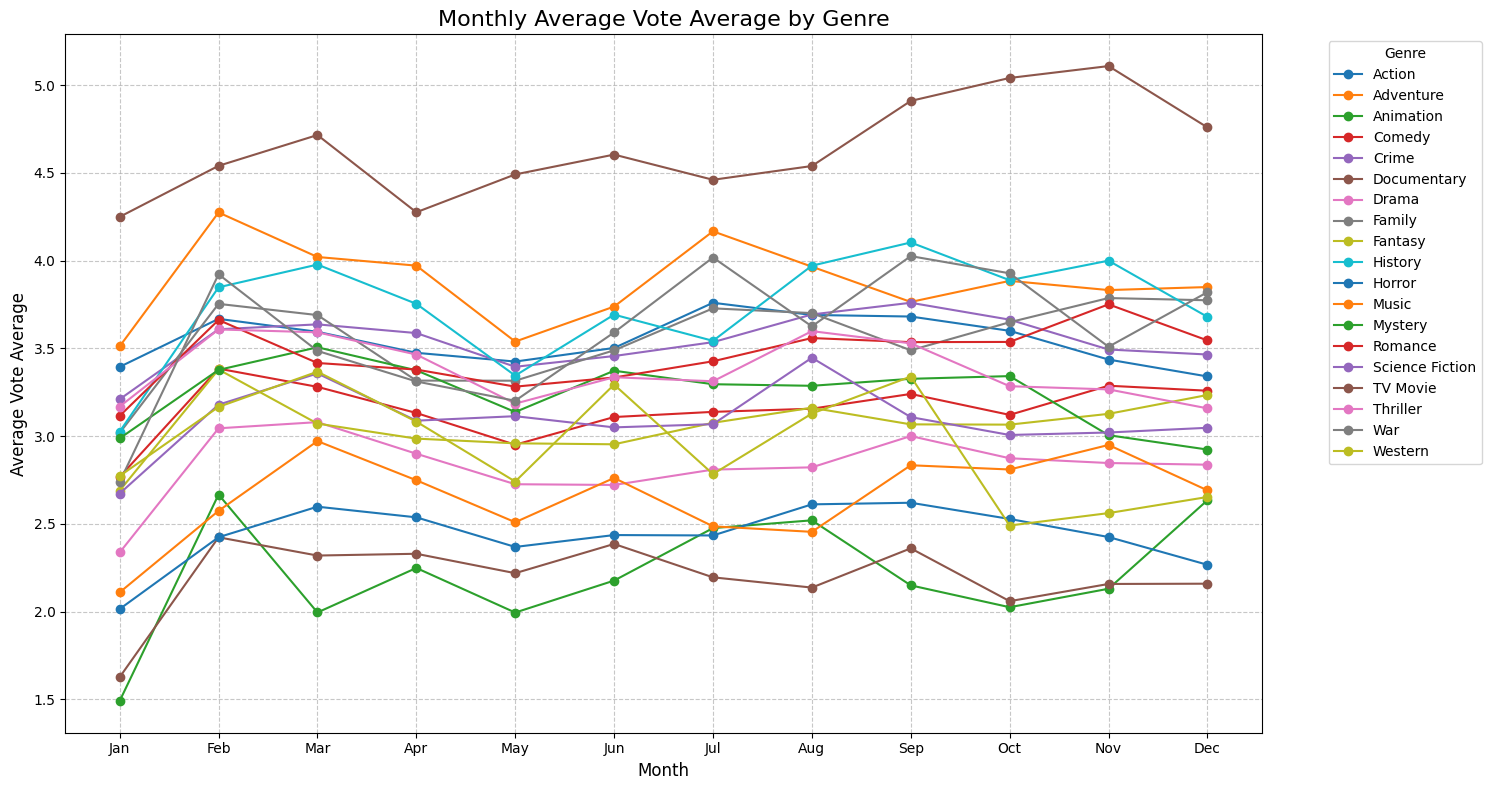

✅ 'monthly_genre_vote_average_line_chart.png' 파일이 저장되었습니다.


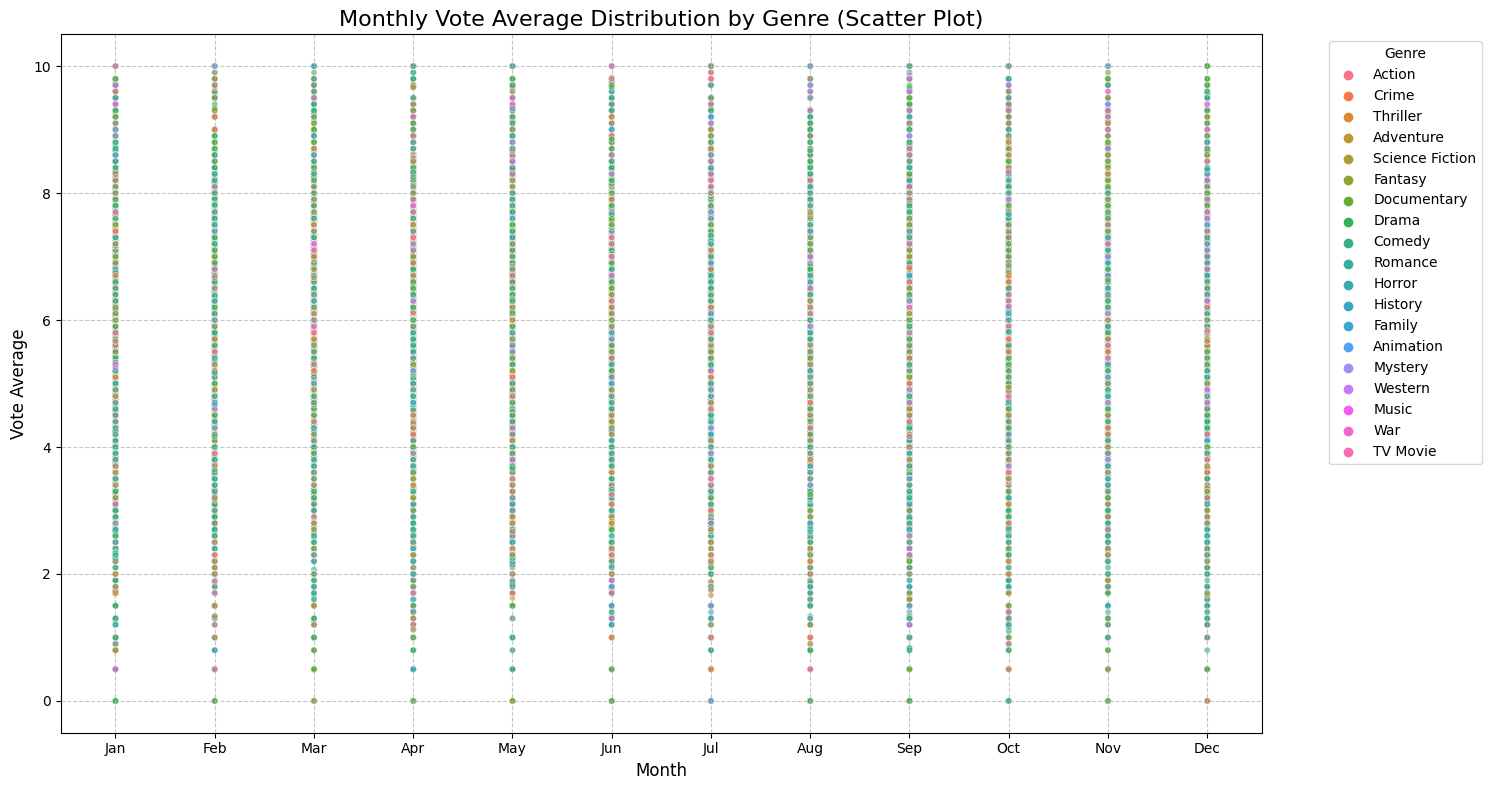

✅ 'monthly_genre_vote_average_scatter_plot.png' 파일이 저장되었습니다.


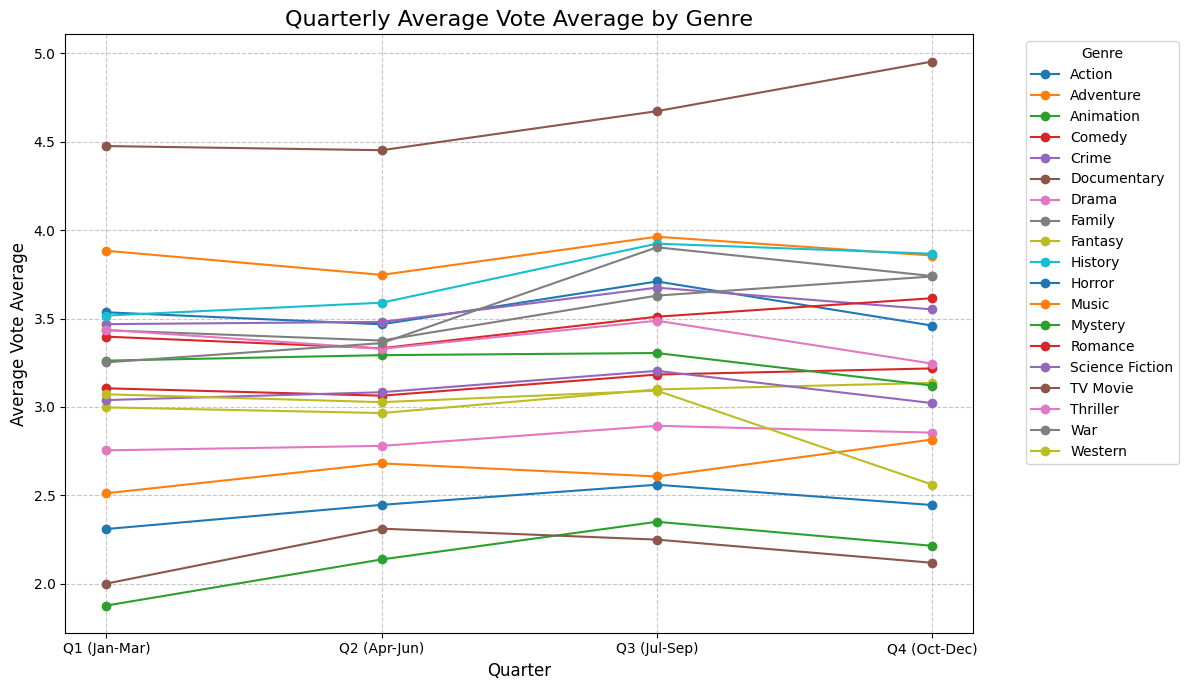

✅ 'quarterly_genre_vote_average_line_chart.png' 파일이 저장되었습니다.


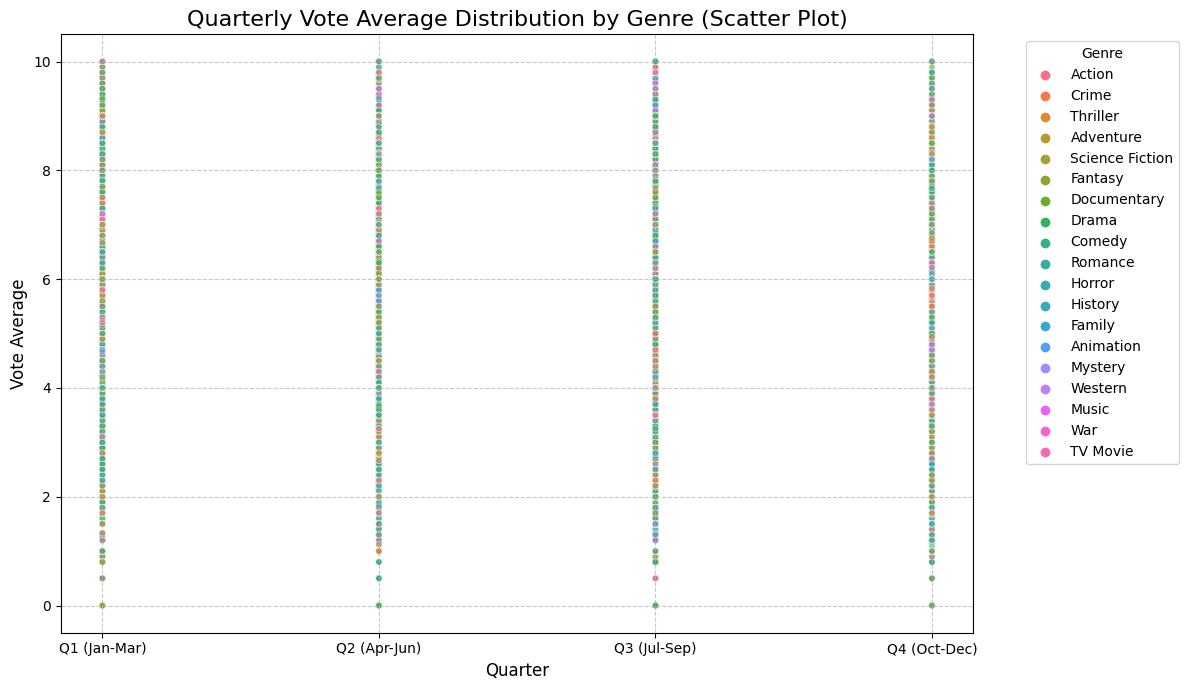

✅ 'quarterly_genre_vote_average_scatter_plot.png' 파일이 저장되었습니다.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 이전 단계에서 장르가 분리된 파일 경로
input_file = '/kaggle/working/genres_split.csv'

try:
    # 1. CSV 파일 읽어오기
    df = pd.read_csv(input_file)

    # 2. 'release_date' 컬럼을 datetime 형식으로 변환 (한글 주석)
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

    # 3. 유효한 날짜와 평점 데이터만 남기기 (결측치 제거)
    df_cleaned = df.dropna(subset=['release_date', 'vote_average', 'genres'])

    # 4. 월과 분기 컬럼 생성
    df_cleaned['release_month'] = df_cleaned['release_date'].dt.month
    df_cleaned['release_quarter'] = df_cleaned['release_date'].dt.quarter

    # --- 시각화 설정 ---
    # Matplotlib 폰트 설정 (영어 전용)
    plt.rcParams['font.family'] = 'sans-serif' # 일반적인 영어 폰트
    plt.rcParams['font.sans-serif'] = ['Arial'] # Arial 폰트 사용
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

    # ----------------------------------------------------
    # 📈 1. 월별 장르별 평점 "평균" (라인 차트)
    # ----------------------------------------------------
    plt.figure(figsize=(15, 8))
    # 월별, 장르별 "평균" 평점 계산
    monthly_avg_rating = df_cleaned.groupby(['release_month', 'genres'])['vote_average'].mean().unstack()

    # 라인 차트로 그리기
    monthly_avg_rating.plot(kind='line', ax=plt.gca(), marker='o')

    plt.title('Monthly Average Vote Average by Genre', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Vote Average', fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # 이미지 파일로 저장
    plt.savefig('monthly_genre_vote_average_line_chart.png')
    plt.show()
    plt.close() # 현재 figure를 닫아 메모리 확보

    print("✅ 'monthly_genre_vote_average_line_chart.png' 파일이 저장되었습니다.")
    
    # ----------------------------------------------------
    # 📉 2. 월별 장르별 평점 "분포" (스캐터 플롯) - 요청하신 사항
    # ----------------------------------------------------
    plt.figure(figsize=(15, 8))
    # 스캐터 플롯: x축=월, y축=평점, 색상=장르
    # alpha=0.5: 점이 겹칠 때를 대비해 투명도 조절
    # s=15: 점 크기 조절
    sns.scatterplot(
        x='release_month', 
        y='vote_average', 
        hue='genres', 
        data=df_cleaned, 
        alpha=0.6, 
        s=20, 
        legend=True # 범례 표시
    )
    
    plt.title('Monthly Vote Average Distribution by Genre (Scatter Plot)', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Vote Average', fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, linestyle='--', alpha=0.7)
    # 범례가 길어질 수 있으므로, 그래프 바깥쪽에 배치
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # 이미지 파일로 저장
    plt.savefig('monthly_genre_vote_average_scatter_plot.png')
    plt.show()
    plt.close()

    print("✅ 'monthly_genre_vote_average_scatter_plot.png' 파일이 저장되었습니다.")

    # ----------------------------------------------------
    # 📈 3. 분기별 장르별 평점 "평균" (라인 차트)
    # ----------------------------------------------------
    plt.figure(figsize=(12, 7))
    # 분기별, 장르별 "평균" 평점 계산
    quarterly_avg_rating = df_cleaned.groupby(['release_quarter', 'genres'])['vote_average'].mean().unstack()
    
    # 라인 차트로 그리기
    quarterly_avg_rating.plot(kind='line', ax=plt.gca(), marker='o')

    plt.title('Quarterly Average Vote Average by Genre', fontsize=16)
    plt.xlabel('Quarter', fontsize=12)
    plt.ylabel('Average Vote Average', fontsize=12)
    plt.xticks(range(1, 5), ['Q1 (Jan-Mar)', 'Q2 (Apr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dec)'])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # 이미지 파일로 저장
    plt.savefig('quarterly_genre_vote_average_line_chart.png')
    plt.show()
    plt.close()

    print("✅ 'quarterly_genre_vote_average_line_chart.png' 파일이 저장되었습니다.")

    # ----------------------------------------------------
    # 📉 4. 분기별 장르별 평점 "분포" (스캐터 플롯) - 요청하신 사항
    # ----------------------------------------------------
    plt.figure(figsize=(12, 7))
    # 스캐터 플롯: x축=분기, y축=평점, 색상=장르
    sns.scatterplot(
        x='release_quarter', 
        y='vote_average', 
        hue='genres', 
        data=df_cleaned, 
        alpha=0.6, 
        s=20, 
        legend=True
    )
    
    plt.title('Quarterly Vote Average Distribution by Genre (Scatter Plot)', fontsize=16)
    plt.xlabel('Quarter', fontsize=12)
    plt.ylabel('Vote Average', fontsize=12)
    plt.xticks(range(1, 5), ['Q1 (Jan-Mar)', 'Q2 (Apr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dec)'])
    plt.grid(True, linestyle='--', alpha=0.7)
    # 범례를 그래프 바깥쪽에 배치
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # 이미지 파일로 저장
    plt.savefig('quarterly_genre_vote_average_scatter_plot.png')
    plt.show()
    plt.close()

    print("✅ 'quarterly_genre_vote_average_scatter_plot.png' 파일이 저장되었습니다.")

except FileNotFoundError:
    print(f"❌ 오류: '{input_file}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
except Exception as e:
    print(f"오류가 발생했습니다: {e}")

# 2. 수익 기준

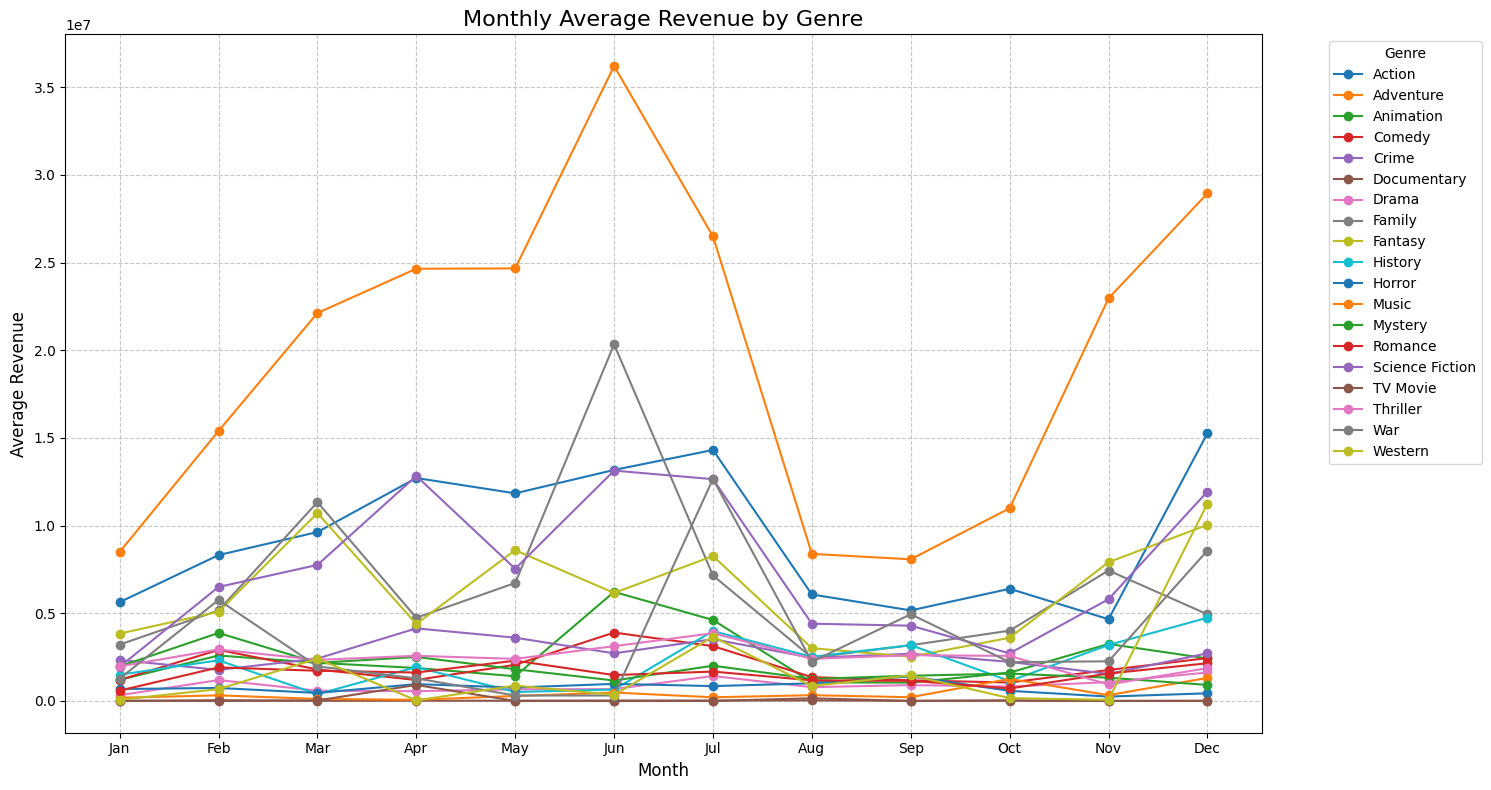

✅ 'monthly_genre_revenue_line_chart.png' 파일이 저장되었습니다.


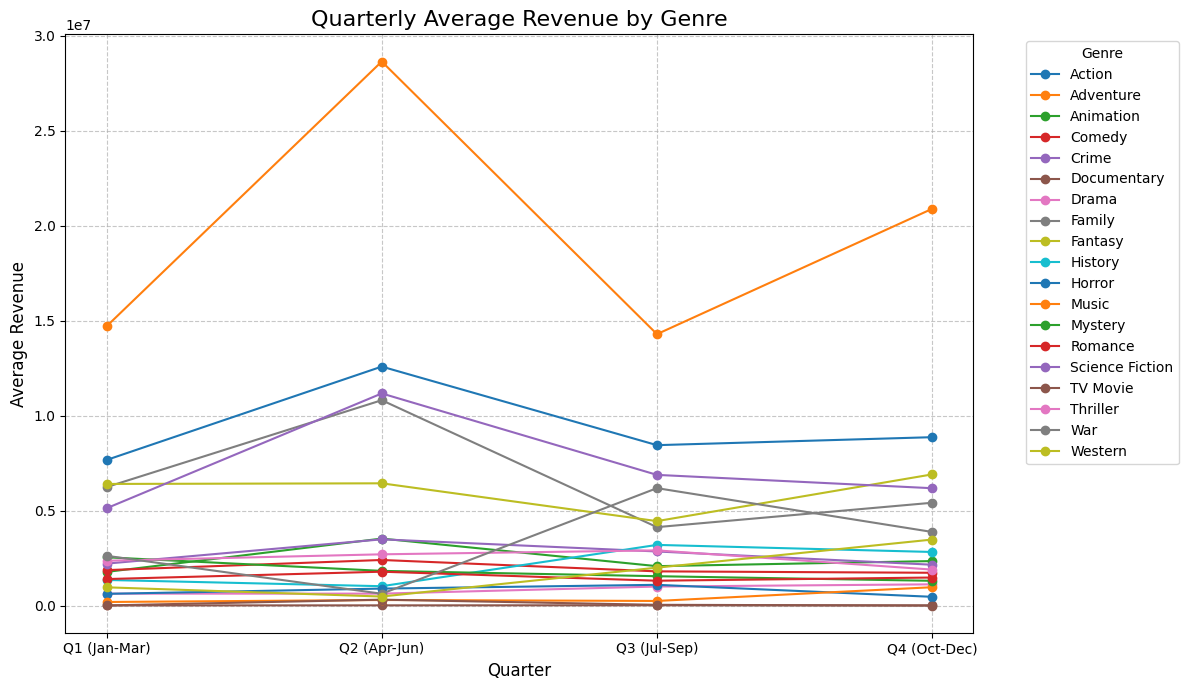

✅ 'quarterly_genre_revenue_line_chart.png' 파일이 저장되었습니다.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 이전 단계에서 장르가 분리된 파일 경로
input_file = '/kaggle/working/genres_split.csv'

try:
    # 1. CSV 파일 읽어오기
    df = pd.read_csv(input_file)

    # 2. 'release_date' 컬럼을 datetime 형식으로 변환 (한글 주석)
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

    # 3. 유효한 날짜와 "수익(revenue)" 데이터만 남기기 (결측치 제거)
    # 'vote_average' 대신 'revenue' 기준으로 결측치 제거
    df_cleaned = df.dropna(subset=['release_date', 'revenue', 'genres'])

    # 4. 월과 분기 컬럼 생성
    df_cleaned['release_month'] = df_cleaned['release_date'].dt.month
    df_cleaned['release_quarter'] = df_cleaned['release_date'].dt.quarter

    # --- 시각화 설정 ---
    # Matplotlib 폰트 설정 (영어 전용)
    plt.rcParams['font.family'] = 'sans-serif' # 일반적인 영어 폰트
    plt.rcParams['font.sans-serif'] = ['Arial'] # Arial 폰트 사용
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

    # ----------------------------------------------------
    # 📈 1. 월별 장르별 "수익(revenue)" 평균 (라인 차트)
    # ----------------------------------------------------
    plt.figure(figsize=(15, 8))
    # 월별, 장르별 "평균 수익" 계산
    monthly_avg_revenue = df_cleaned.groupby(['release_month', 'genres'])['revenue'].mean().unstack()

    # 라인 차트로 그리기
    monthly_avg_revenue.plot(kind='line', ax=plt.gca(), marker='o')

    # 제목 및 레이블 수정
    plt.title('Monthly Average Revenue by Genre', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Revenue', fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # 이미지 파일로 저장
    plt.savefig('monthly_genre_revenue_line_chart.png')
    plt.show()
    plt.close() # 현재 figure를 닫아 메모리 확보

    print("✅ 'monthly_genre_revenue_line_chart.png' 파일이 저장되었습니다.")
    


    # ----------------------------------------------------
    # 📈 3. 분기별 장르별 "수익(revenue)" 평균 (라인 차트)
    # ----------------------------------------------------
    plt.figure(figsize=(12, 7))
    # 분기별, 장르별 "평균 수익" 계산
    quarterly_avg_revenue = df_cleaned.groupby(['release_quarter', 'genres'])['revenue'].mean().unstack()
    
    # 라인 차트로 그리기
    quarterly_avg_revenue.plot(kind='line', ax=plt.gca(), marker='o')

    # 제목 및 레이블 수정
    plt.title('Quarterly Average Revenue by Genre', fontsize=16)
    plt.xlabel('Quarter', fontsize=12)
    plt.ylabel('Average Revenue', fontsize=12) # 'Average Vote Average' -> 'Average Revenue'
    plt.xticks(range(1, 5), ['Q1 (Jan-Mar)', 'Q2 (Apr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dec)'])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # 이미지 파일로 저장
    plt.savefig('quarterly_genre_revenue_line_chart.png')
    plt.show()
    plt.close()

    print("✅ 'quarterly_genre_revenue_line_chart.png' 파일이 저장되었습니다.")


except FileNotFoundError:
    print(f"❌ 오류: '{input_file}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
except Exception as e:
    print(f"오류가 발생했습니다: {e}")

# 3. 인기도 기준

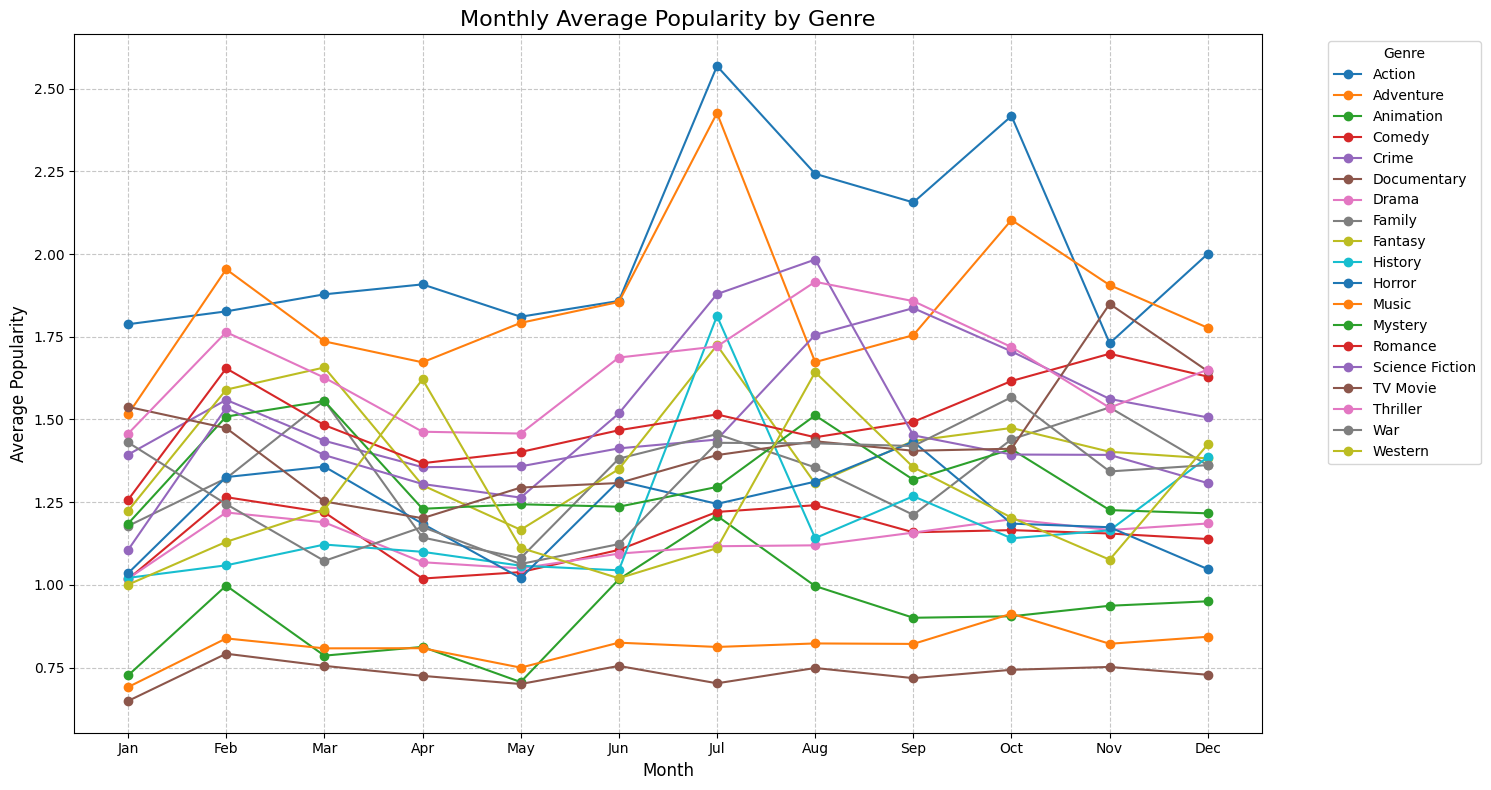

✅ 'monthly_genre_popularity_line_chart.png' 파일이 저장되었습니다.


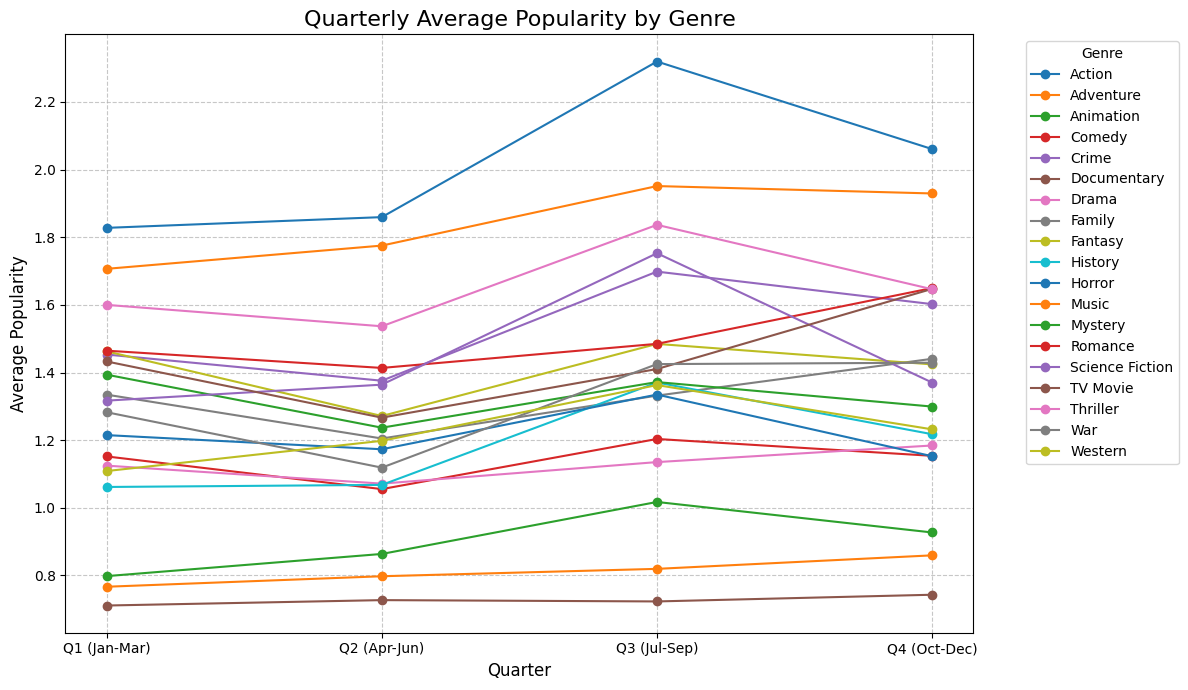

✅ 'quarterly_genre_popularity_line_chart.png' 파일이 저장되었습니다.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 이전 단계에서 장르가 분리된 파일 경로
input_file = '/kaggle/working/genres_split.csv'

try:
    # 1. CSV 파일 읽어오기
    df = pd.read_csv(input_file)

    # 2. 'release_date' 컬럼을 datetime 형식으로 변환
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

    # 3. 유효한 날짜와 "인기도(popularity)" 데이터만 남기기 (결측치 제거)
    # 'revenue' 대신 'popularity' 기준으로 결측치 제거
    df_cleaned = df.dropna(subset=['release_date', 'popularity', 'genres'])

    # 4. 월과 분기 컬럼 생성
    df_cleaned['release_month'] = df_cleaned['release_date'].dt.month
    df_cleaned['release_quarter'] = df_cleaned['release_date'].dt.quarter

    # --- 시각화 설정 ---
    # Matplotlib 폰트 설정 (영어 전용)
    plt.rcParams['font.family'] = 'sans-serif' # 일반적인 영어 폰트
    plt.rcParams['font.sans-serif'] = ['Arial'] # Arial 폰트 사용
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

    # ----------------------------------------------------
    # 📈 1. 월별 장르별 "인기도(popularity)" 평균 (라인 차트)
    # ----------------------------------------------------
    plt.figure(figsize=(15, 8))
    # 월별, 장르별 "평균 인기도" 계산
    monthly_avg_popularity = df_cleaned.groupby(['release_month', 'genres'])['popularity'].mean().unstack()

    # 라인 차트로 그리기
    monthly_avg_popularity.plot(kind='line', ax=plt.gca(), marker='o')

    # 제목 및 레이블 수정
    plt.title('Monthly Average Popularity by Genre', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Popularity', fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # 이미지 파일로 저장
    plt.savefig('monthly_genre_popularity_line_chart.png')
    plt.show()
    plt.close() # 현재 figure를 닫아 메모리 확보

    print("✅ 'monthly_genre_popularity_line_chart.png' 파일이 저장되었습니다.")
    

    # ----------------------------------------------------
    # 📈 3. 분기별 장르별 "인기도(popularity)" 평균 (라인 차트)
    # ----------------------------------------------------
    plt.figure(figsize=(12, 7))
    # 분기별, 장르별 "평균 인기도" 계산
    quarterly_avg_popularity = df_cleaned.groupby(['release_quarter', 'genres'])['popularity'].mean().unstack()
    
    # 라인 차트로 그리기
    quarterly_avg_popularity.plot(kind='line', ax=plt.gca(), marker='o')

    # 제목 및 레이블 수정
    plt.title('Quarterly Average Popularity by Genre', fontsize=16)
    plt.xlabel('Quarter', fontsize=12)
    plt.ylabel('Average Popularity', fontsize=12)
    plt.xticks(range(1, 5), ['Q1 (Jan-Mar)', 'Q2 (Apr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dec)'])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # 이미지 파일로 저장
    plt.savefig('quarterly_genre_popularity_line_chart.png')
    plt.show()
    plt.close()

    print("✅ 'quarterly_genre_popularity_line_chart.png' 파일이 저장되었습니다.")


except FileNotFoundError:
    print(f"❌ 오류: '{input_file}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
except Exception as e:
    print(f"오류가 발생했습니다: {e}")

# 너무 많아서 상위 5개만 확인하기 

In [6]:
import pandas as pd
import numpy as np

# 장르가 분리된 파일 경로
input_file = '/kaggle/working/genres_split.csv' 
# (경로는 /kaggle/working/genres_split.csv 등 환경에 맞게 사용하세요)

try:
    # 1. CSV 파일 읽어오기
    df = pd.read_csv(input_file)

    # 2. 분석할 컬럼 리스트
    columns_to_analyze = ['revenue', 'vote_average', 'popularity']
    
    print("--- 장르별 컬럼 평균 상위 5개 장르 분석 ---")

    for col in columns_to_analyze:
        # 3. 해당 컬럼에 결측치가 없는 데이터만 필터링
        df_cleaned = df.dropna(subset=[col, 'genres'])
        
        # 4. 장르(genres)별로 해당 컬럼(col)의 평균 계산
        genre_mean = df_cleaned.groupby('genres')[col].mean()
        
        # 5. 평균값이 가장 높은 상위 5개 장르 찾기
        # sort_values(ascending=False)로 내림차순 정렬 후 head(5)로 5개 선택
        top_5_genres = genre_mean.sort_values(ascending=False).head(5)
        
        # 6. 결과 출력
        print(f"\n## '{col}' 컬럼 상위 5개 장르 ##")
        # to_string을 사용하여 깔끔하게 출력 (값 포맷팅 적용)
        print(top_5_genres.to_string(float_format='{:,.2f}'.format))

except FileNotFoundError:
    print(f"❌ 오류: '{input_file}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
except Exception as e:
    print(f"오류가 발생했습니다: {e}")

--- 장르별 컬럼 평균 상위 5개 장르 분석 ---

## 'revenue' 컬럼 상위 5개 장르 ##
genres
Adventure         19,606,155.73
Action             9,376,286.94
Science Fiction    7,367,766.98
Family             6,490,425.09
Fantasy            6,102,811.02

## 'vote_average' 컬럼 상위 5개 장르 ##
genres
TV Movie    4.67
Adventure   3.86
History     3.72
Family      3.56
War         3.55

## 'popularity' 컬럼 상위 5개 장르 ##
genres
Action      2.02
Adventure   1.85
Thriller    1.66
Crime       1.53
Romance     1.51
